In [196]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import scipy

In [197]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0


def make_chain(epLen=20):
    '''
    Makes the benchmark RiverSwim MDP.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nState = epLen
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (0.000, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.
        P_true[s, 1][min(nState-1, s+1)] = 1.
        R_true[s, 1] = (-.01/(epLen-1), 0)


    R_true[nState - 1, 1] = (1, 0)
    

    chain = TabularMDP(nState, nAction, epLen)
    chain.R = R_true
    chain.P = P_true
    chain.states = states
    chain.reset()

    return chain

class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState

    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0

    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])

        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd

    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [198]:
class LSVI_UCB(object):
    def __init__(self,env,K,delta):
        self.env = env
        self.K = K
        self.p = delta
        self.d = self.env.nState * self.env.nAction
        self.lam = 1.0
        self.Lambda = {h: self.lam*np.identity(self.d) for h in range(self.env.epLen)}
        self.L = {h: (self.lam)*np.identity(self.d) for h in range(self.env.epLen)}
        self.Linv = {h: (1/self.lam)*np.identity(self.d) for h in range(self.env.epLen)}
        self.w = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        self.features_state_action = {(s,a): np.zeros(self.d) for s in self.env.states.keys() \
                                      for a in range(self.env.nAction)}
        self.createIdentity()
        self.buffer = {h: [] for h in range(self.env.epLen)}
        self.sums = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.c = 1.0
        self.m_2 = 3.0 #choosing this is constant is very important, how to do so is not simple though...
        
    
    def createIdentity(self):
        '''
            A function that creates the Identity Matrix for a Dictionary
        '''
        i = 0
        for key in self.features_state_action.keys():
            self.features_state_action[key][i] = 1
            i += 1
        j = 0
    
    def update_buffer(self,s,a,r,s_,h):
        self.buffer[h].append((s,a,r,s_))
    
    def reset_buffer(self):
        self.buffer = {h: [] for h in range(self.env.epLen)}
    
    def update(self):
        
        Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        for h in range(self.env.epLen-1,-1,-1):
            d = self.buffer[h]
            s,a,r,s_ = d[0][0],d[0][1],d[0][2],d[0][3]
            
            self.L[h] = self.L[h] + np.outer(self.features_state_action[s,a],self.features_state_action[s,a])
            
            self.Linv[h] = self.Linv[h] - np.dot((np.outer(np.dot(self.Linv[h],self.features_state_action[s,a]) \
                 ,self.features_state_action[s,a])),self.Linv[h]) / \
                    (1 + np.dot(np.dot(self.features_state_action[s,a],self.Linv[h]),self.features_state_action[s,a]))
            
            self.sums[h] = self.sums[h] + self.features_state_action[s,a]*(env.R[s,a][0] + \
                                             max(np.array([Q[(h+1,s_,a)] for a in range(self.env.nAction)])))
            
            self.w[h] = np.matmul(self.Linv[h],self.sums[h])
            for ss in self.env.states.keys():
                for aa in range(env.nAction):
                    feature = self.features_state_action[ss,aa]
                    Q[h,ss,aa] = min(np.inner(self.w[h],feature) + self.Beta(h) \
                                    * np.sqrt(np.dot(np.dot(feature,self.Linv[h]),feature)),self.env.epLen)
        self.Q = Q.copy()
    
    def act(self,s,h):
        '''
        A function that returns the argmax of Q given the state and timestep
        '''
        return self.env.argmax(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
                    
    
    def Beta(self,h):
        '''
        iota = np.log(2*self.d*self.K*self.env.epLen/self.p)
        return self.c * self.d * (self.env.epLen-h)/2 * np.sqrt(iota)
        '''
        
        first = self.m_2 * np.sqrt(self.lam)
        second = np.sqrt(2*np.log(1/self.p) + np.log(np.linalg.det(self.L[h])/self.lam))
        return first + second
        
    
    def run(self):
        R = 0
        Rvec = []
        for k in (range(1,self.K+1)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update_buffer(s,a,r,s_,h)
                R += r
            Rvec.append(R)
            self.update()
            self.reset_buffer()
        return Rvec
        

In [199]:
class LSVI_EG(object):
    def __init__(self,env,K,eps):
        self.env = env
        self.K = K
        self.eps = eps
        self.d = self.env.nState * self.env.nAction
        self.lam = 1.0
        self.Lambda = {h: self.lam*np.identity(self.d) for h in range(self.env.epLen)}
        self.L = {h: (self.lam)*np.identity(self.d) for h in range(self.env.epLen)}
        self.Linv = {h: (1/self.lam)*np.identity(self.d) for h in range(self.env.epLen)}
        self.w = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        self.features_state_action = {(s,a): np.zeros(self.d) for s in self.env.states.keys() \
                                      for a in range(self.env.nAction)}
        self.createIdentity()
        self.buffer = {h: [] for h in range(self.env.epLen)}
        self.sums = {h: np.zeros(self.d) for h in range(self.env.epLen)}
        self.p = 1/2
        self.m_2 = np.sqrt(self.d) #choosing this is constant is very important, how to do so is not simple though...
        
    
    def createIdentity(self):
        '''
            A function that creates the Identity Matrix for a Dictionary
        '''
        i = 0
        for key in self.features_state_action.keys():
            self.features_state_action[key][i] = 1
            i += 1
        j = 0
    
    def update_buffer(self,s,a,r,s_,h):
        self.buffer[h].append((s,a,r,s_))
    
    def reset_buffer(self):
        self.buffer = {h: [] for h in range(self.env.epLen)}
    
    def update(self):
        
        Q = {(h,s,a): 0.0 for h in range(self.env.epLen+1) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        for h in range(self.env.epLen-1,-1,-1):
            d = self.buffer[h]
            s,a,r,s_ = d[0][0],d[0][1],d[0][2],d[0][3]
            
            self.L[h] = self.L[h] + np.outer(self.features_state_action[s,a],self.features_state_action[s,a])
            
            self.Linv[h] = self.Linv[h] - np.dot((np.outer(np.dot(self.Linv[h],self.features_state_action[s,a]) \
                 ,self.features_state_action[s,a])),self.Linv[h]) / \
                    (1 + np.dot(np.dot(self.features_state_action[s,a],self.Linv[h]),self.features_state_action[s,a]))
            
            self.sums[h] = self.sums[h] + self.features_state_action[s,a]*(env.R[s,a][0] + \
                                             max(np.array([Q[(h+1,s_,a)] for a in range(self.env.nAction)])))
            
            self.w[h] = np.matmul(self.Linv[h],self.sums[h])
            for ss in self.env.states.keys():
                aa = self.env.argmax(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
                if aa == 0:
                    feature = self.features_state_action[ss,0]
                    Q[h,ss,0] = (1-self.eps/2)*(np.inner(self.w[h],feature))
                    feature = self.features_state_action[ss,1]
                    Q[h,ss,1] = (self.eps/2)*(np.inner(self.w[h],feature))
                else:
                    feature = self.features_state_action[ss,1]
                    Q[h,ss,1] = (1-self.eps/2)*(np.inner(self.w[h],feature))
                    feature = self.features_state_action[ss,0]
                    Q[h,ss,0] = (self.eps/2)*(np.inner(self.w[h],feature))
        self.Q = Q.copy()
    
    def act(self,s,h):
        '''
        A function that returns the argmax of Q given the state and timestep
        '''
        c = np.random.uniform()
        if c > self.eps:
            return self.env.argmax(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
        else:
            return np.random.choice(np.array([0,1]))
    
    def run(self):
        R = 0
        Rvec = []
        for k in (range(1,self.K+1)):
            env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update_buffer(s,a,r,s_,h)
                R += r
            Rvec.append(R)
            self.update()
            self.reset_buffer()
        return Rvec
                    
    

        
        

In [200]:
K = 10000

In [203]:
nState = 8
Eps = np.geomspace(0.0001,0.1,num=10)
EG_mat = np.zeros((nState,len(Eps),2))
EG_sem = np.zeros((nState,len(Eps)))
Rmax = np.zeros((nState,K)) 
eps_max = np.zeros(nState)
Trials = 30
max_sem_eps = []
for n in tqdm(range(nState)):
    env = make_chain(epLen=n+2)
    i = 0
    for eps in tqdm(Eps):    
        Rmat = np.zeros((Trials,K))
        for trials in (range(Trials)):
            agent = LSVI_EG(env,K,eps)
            Rvec = agent.run()
            Rmat[trials,:] = Rvec
        EG_mat[n,i,0] = eps
        EG_mat[n,i,1] = np.mean(Rmat[:,-1])
        EG_sem[n,i] = scipy.stats.sem(Rmat[:,-1])
        if Rmax[n,-1] < np.mean(Rmat[:,-1]):
            Rmax[n,:] = np.mean(Rmat,axis=0)
            eps_max[n] = int(i)
            max_sem_eps.append(2.5*EG_sem[n,i])
        i += 1
    print(eps_max[n])


6.0



9.0



9.0



9.0



5.0



9.0



0.0



0.0



[7.14013082e+00 5.88273758e+01 6.51961528e+02 4.93980072e+02
 1.97728373e+02 2.19929048e+02 4.05398215e-02 4.54475404e-02]


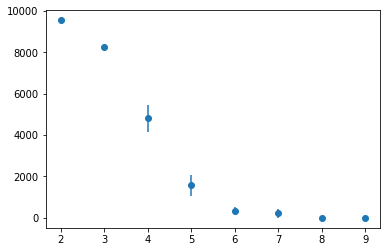

In [204]:
print(EG_sem[:,-1])
plt.errorbar(range(2,2+nState),Rmax[:,-1],yerr=EG_sem[:,-1],fmt='o')
plt.show()

In [208]:
np.save("RmaxEps.npy",Rmax)
np.save("EG_mat.npy",EG_mat)
np.save("EG_sem.npy",EG_sem)
np.save("MaxSemEps.npy",max_sem_eps)
np.save("EpsMax.npy",eps_max)

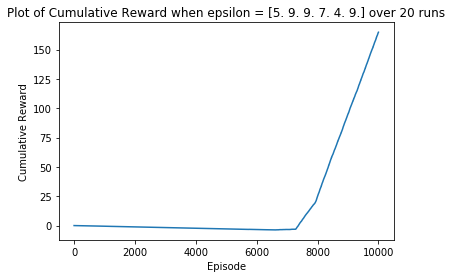

In [167]:
plt.plot(Rmax[-1,:])
plt.title("Plot of Cumulative Reward when epsilon = " + str(eps_max) + " over " + str(Trials) + " runs")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()

In [186]:
nState = 6
Delta = np.geomspace(1/K,1,num=10)
UCB_mat = np.zeros((nState,len(Delta),2))
UCB_sem = np.zeros((nState,len(Delta)))
RmaxUCB = np.zeros((nState,K)) 
delta_max = np.zeros(nState)
Trials = 30
max_sem_ucb = np.zeros(nState)
for n in tqdm(range(nState)):
    env = make_chain(epLen=n+2)
    i = 0
    for delta in tqdm(Delta):    
        RmatUCB = np.zeros((Trials,K))
        for trials in (range(Trials)):
            agent = LSVI_UCB(env,K,delta)
            Rvec = agent.run()
            RmatUCB[trials,:] = Rvec
        UCB_mat[n,i,0] = delta
        UCB_mat[n,i,1] = np.mean(RmatUCB[:,-1])
        UCB_sem[n,i] = scipy.stats.sem(RmatUCB[:,-1])
        if RmaxUCB[n,-1] < np.mean(RmatUCB[:,-1]):
            RmaxUCB[n,:] = np.mean(RmatUCB,axis=0)
            delta_max[n] = int(i)
            max_sem_ucb[n] = UCB_sem[n,i]
        i += 1
    print(delta_max[n])


2.0



2.0



2.0



2.0



2.0



1.0



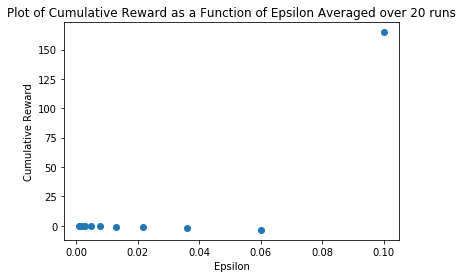

In [168]:
plt.errorbar(EG_mat[-1,:,0],EG_mat[-1,:,1],fmt='o')
plt.title("Plot of Cumulative Reward as a Function of Epsilon Averaged over " + str(Trials) + " runs")
plt.xlabel("Epsilon")
plt.ylabel("Cumulative Reward")
plt.show()

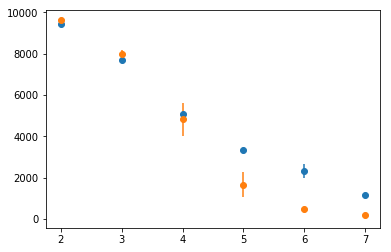

In [195]:
plt.errorbar(range(2,2+nState),UCB_mat[:,2,-1],yerr=max_sem_ucb,fmt='o')
plt.errorbar(range(2,2+nState),Rmax[:,-1],yerr=EG_sem[:,-1],fmt='o')
plt.show()

In [142]:
np.save("RmaxUCB.npy",RmaxUCB)
np.save("UCB_mat.npy",UCB_mat)
np.save("UCB_sem.npy",UCB_sem)
np.save("MaxSemUCB.npy",max_sem_ucb)

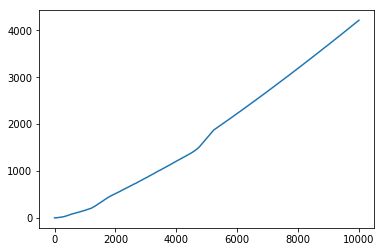

In [146]:
plt.plot(RmaxUCB[0,:])

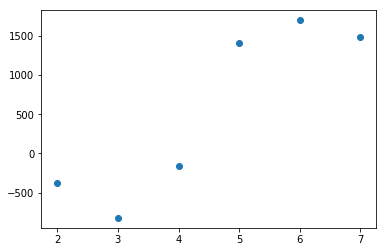

In [188]:
plt.scatter(range(2,2+nState),UCB_mat[:,0,1]-Rmax[:,-1])